In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from collections import OrderedDict
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
import torchvision.models as models
model = models.resnet18(pretrained = True)
model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 23707805.35it/s]


In [3]:
train_dir = '../input/train/train'
test_dir = '../input/test1/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [4]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import torchvision
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

In [5]:
dataloader = DataLoader(catdogs, batch_size = 64, shuffle=True, num_workers=4)

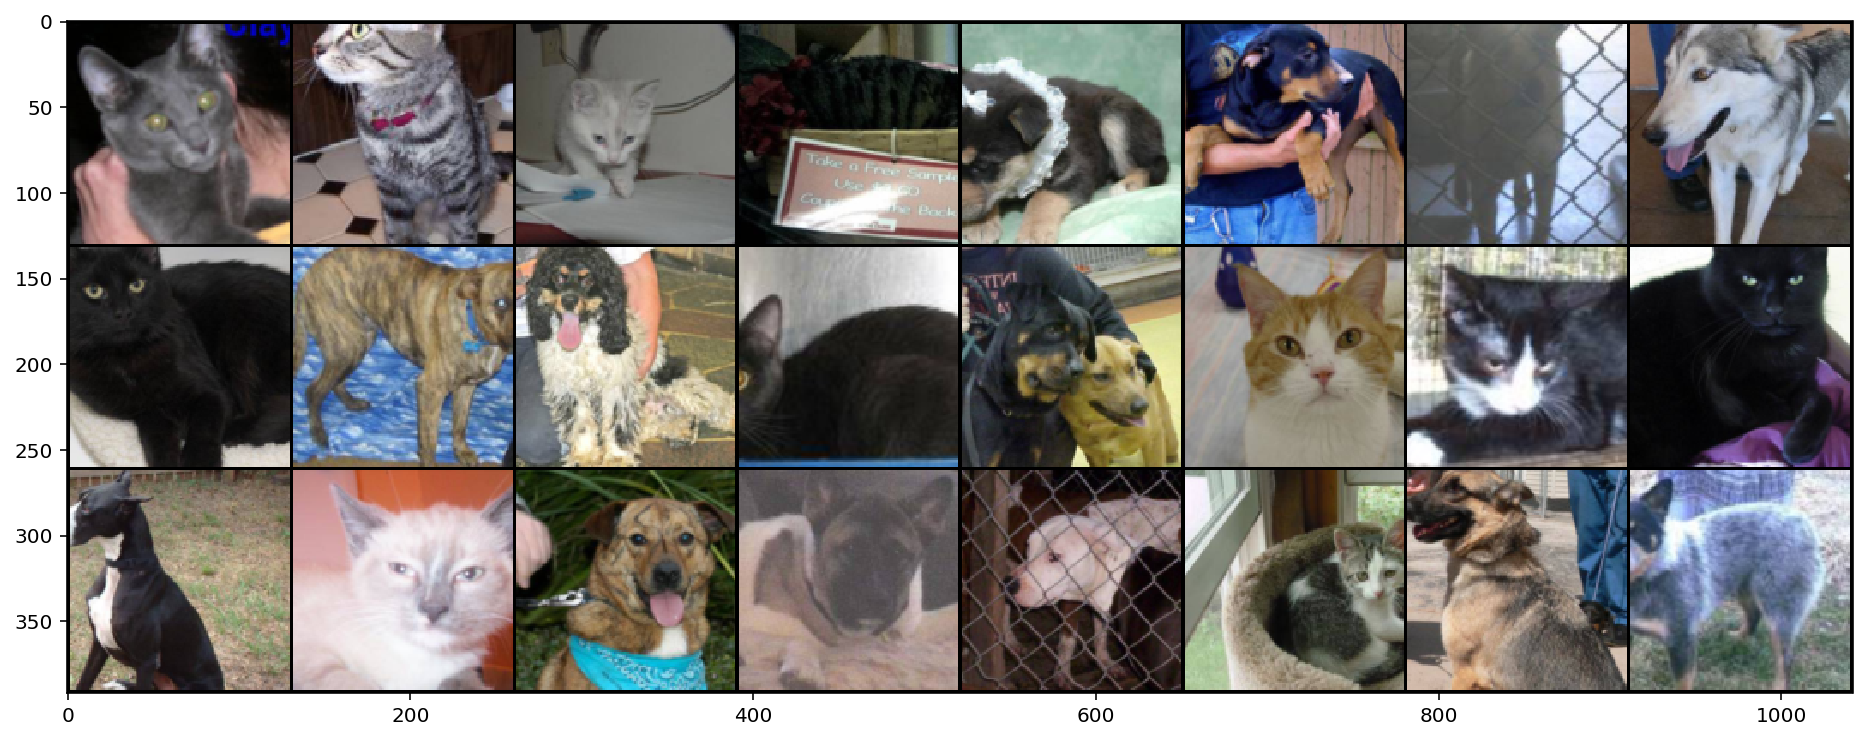

In [6]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [7]:
for param in model.parameters():
    param.requires_grad = False 

In [8]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100,2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc

In [9]:
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Epoch : 1/3.. Training Loss: 0.197449
Epoch : 2/3.. Training Loss: 0.161453
Epoch : 3/3.. Training Loss: 0.153710


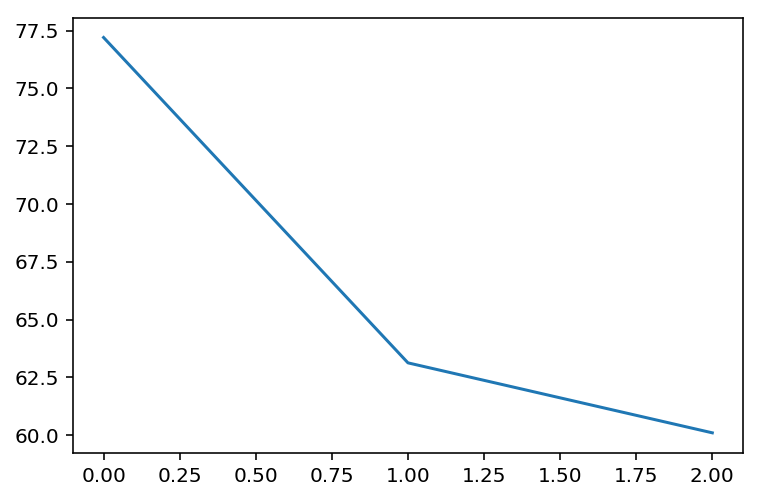

In [10]:
def train(model, trainloader, criterion, optimizer, epochs = 5):
    train_loss =[]
    for e in range(epochs):
        running_loss =0
        for images, labels in trainloader:
            inputs, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            img = model(inputs)
            
            loss = criterion(img, labels)
            running_loss+=loss
            loss.backward()
            optimizer.step()
        print("Epoch : {}/{}..".format(e+1,epochs),
         "Training Loss: {:.6f}".format(running_loss/len(trainloader))) 
        train_loss.append(running_loss)
    plt.plot(train_loss,label="Training Loss")
    plt.show() 
    
    
    
epochs = 3
model.train()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.NLLLoss()    
train(model,dataloader,criterion, optimizer, epochs)            
            

In [11]:
filename_pth = 'ckpt_resnet18_catdog.pth'
torch.save(model.state_dict(), filename_pth)

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 64, shuffle=False, num_workers=4)

In [12]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('preds_resnet18.csv', index=False)

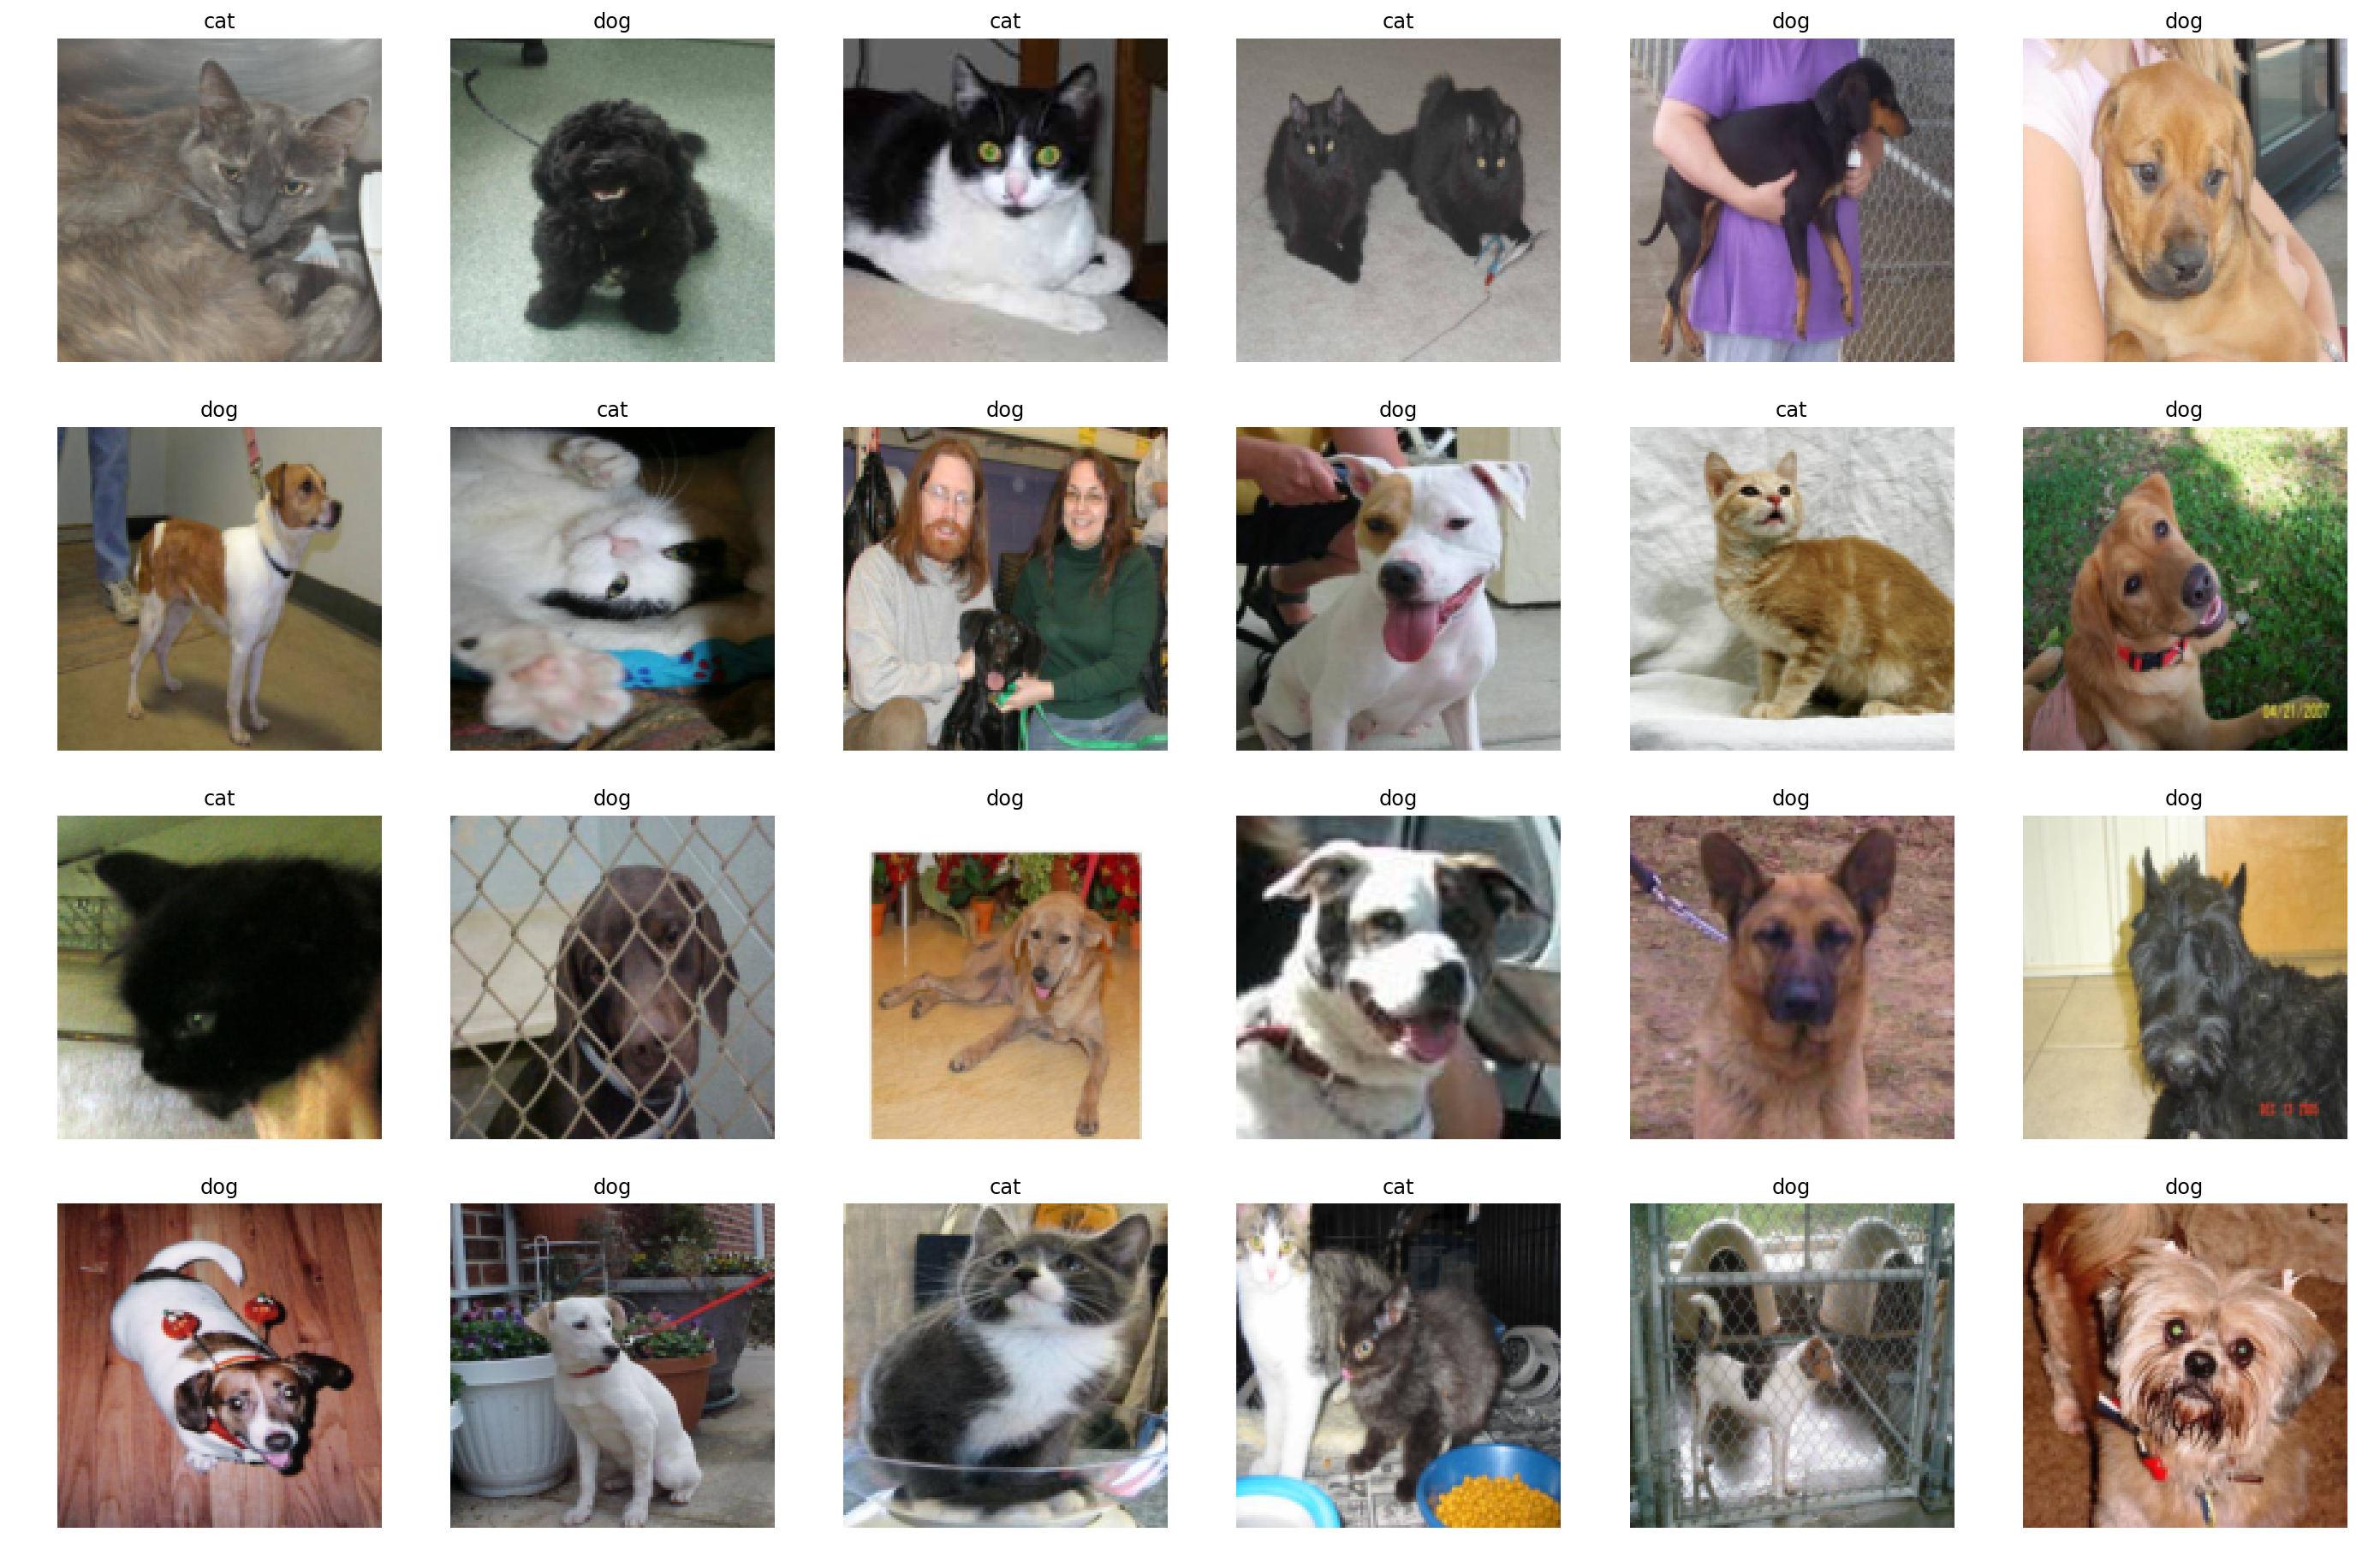

In [13]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))